***
<center><h1>Face Rhythm</h1></center>

***

<table><tr>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723283221-5Z5038AT7Y6KCOM2PIU4/Screenshot+from+2021-03-02+17-05-12.png?content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723856628-J89PYYSF7K7JATE2KMF9/Screenshot+from+2021-03-02+17-23-46.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723931026-OORV0RAPZNWV3R8TBOXB/Screenshot+from+2021-03-02+17-25-11.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614724055033-O3GBEF1D9MULFZKI2IUJ/Screenshot+from+2021-03-02+17-27-10.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723378405-WXN74ZTT1KYZUQGDM07X/face_rhythm_banner2.png?format=1000w&content-type=image%2Fpng" style="height: 200px"> </td>
</tr></table>

***

##### Notebook Shortcuts
- **[Notebook Setup](#Notebook-Setup)**: Prepare all the necessary config files and folders
- **[Set ROI](#Set-ROI)**: Set the ROI for the analysis
- **[Run Optic Flow](#Run-Optic-Flow)**: Run the optic flow analysis
- **[Clean Optic Flow](#Clean-Optic-Flow)**: Optic flow post-processing
- **[Convolutional Dimensionality Reduction](#Convolutional-Dimensionality-Reduction)**: Convolutional Dimensionality Reduction
- **[Analysis](#Analysis)**: Decompose and Analyze the optic flow data in many ways
- **[Comparisons](#Comparisons)**: Compare Face Rhythm to some peer algorithms

***

# Tips on running this notebook:
In theory it would be nice if you could just enter the path of the video(s) and just let it run all the way through. In practice, there are a few hoops to jump through
- Run the Notebook Setup Block (two blocks below this one). This should pretty much always be done, even if you are loading precomputed file from disk instead of calculating them. This step loads in some useful meta data used throughout.
- Even if you are restarting at a specific point in your analysis, run your Setup Block then head down to your current analysis step cell 

# Project Directory Organization
------------

    Project Directory
    ├── config.yaml           <- Configuration parameters to run each module in the pipeline. Dictionary.
    ├── run_info.json         <- Output information from each module. Dictionary.
    │
    ├── run_data              <- Output data from each module.
    │   ├── Dataset_videos.h5 <- Output data from Dataset_videos class. Contains metadata about the videos.
    │   ├── ROIs.h5           <- Output data from ROIs class. Contains ROI masks.
    │   ├── PointTracker.h5   <- Output data from PointTracker class. Contains point tracking data.
    |   ├── VQT_Analyzer.h5   <- Output data from VQT_Analyzer class. Contains spectral decomposition data.
    │   ├── TCA.h5            <- Output data from TCA class. Contains TCA decomposition data.
    │   
    └── visualizations        <- Output visualizations.
        ├── factors_rearranged_[frequency].png  <- Example of a rearranged factor plot.
        └── point_tracking_demo.avi             <- Example video.



# Shawn's notes

#### Modifications

Modified by Shawn Tan (banchan@gmail.com) for DJ BambahMukku Lab

#### Changelog

3/25/25 - Removed spectral analysis and decomposition sections, modified analysis parameters for DJ lab airpuff setup.

3/26/25 - Added video compression and full video tracking output.

***
<center><h1>Notebook Setup</h1></center>

***

### Creates config and locates videos

**Crucially, always run this first cell every time you run this notebook.**

Also, generally make sure to read through the config parameters before running.

The Project path is the path to a folder (existing or not) where we will store our derived files. I recommend creating a project folder and then copying this notebook into that folder.
The Video path is the path to a folder containing videos. 
The run name will determine the name of the config. You might create multiple configs if you want to re-run the same data with slightly different parameters

Previous face rhythm users might be familiar with the 'sessions' structure. Some users will want to run multiple sessions through Face Rhythm at the same time. If that's you, then read the docs to see what parameters to change:
https://face-rhythm.readthedocs.io/

If you did everything according to the readme, you should see that the video_path currently points to a folder containing one sample video in the testing folder. Give this a try!

In [43]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import face_rhythm as fr

from pprint import pprint
from pathlib import Path

import cv2

import numpy as np
import torch
import matplotlib.pyplot

fr.util.system_info(verbose=True);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
== Operating System ==: uname_result(system='Windows', node='DESKTOP-CDN84AU', release='10', version='10.0.26100', machine='AMD64')
== CPU Info ==: {'n_cores': 12, 'brand': 'AMD Ryzen 5 2600 Six-Core Processor'}
== RAM ==: svmem(total=34305585152, available=8574984192, percent=75.0, used=25730600960, free=8574984192)
== GPU Info ==: {0: {'id': 0, 'uuid': 'GPU-9d2fd93d-c667-a41d-3f3d-a28fb0b5b783', 'load': 0.0, 'memoryUtil': 0.50390625, 'memoryTotal': 8192.0, 'memoryUsed': 4128.0, 'memoryFree': 3890.0, 'driver': '560.94', 'name': 'NVIDIA GeForce RTX 3070 Ti', 'serial': '[N/A]', 'display_mode': 'Enabled', 'display_active': 'Enabled', 'temperature': 43.0}}
== Conda Environment ==: face_rhythm
== Python Version ==: 3.11.11
== GCC Version ==: Faled to get
== PyTorch Version ==: 2.6.0+cpu
== CUDA is not available ==
== face_rhythm Version ==: <module 'face_rhythm' from 'C:\\Users\\shawn\\anaconda3\\envs\\

C:\Users\shawn\anaconda3\envs\face_rhythm\Lib\site-packages\face_rhythm\util.py:1019: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] The system cannot find the file specified
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


In [44]:
# Change these to your desired project path and video path
# Assuming that your notebook is running  in your project directory, 
# then the project directory is current working directory
# Also, we have some test videos in the face_rhythm repo, so you can set the video directory there for testing

# Shawn's note 3/25/25 
# amended this section so that analysis script does not have to be placed in data folder and can be version tracked with git
# currently set up to run face_rhythm for each session (animal) and to save face_rhythm results in each individual session
# added regex to match raw video rather than screen recording

directory_project = str(Path("../../Airpuff_Data/03182025_Cage_PN37/ULM").resolve())
directory_videos = str(Path("../../Airpuff_Data/03182025_Cage_PN37/ULM").resolve())
filename_strMatch = r"^video.*\.avi$"  ## You can use regular expressions to search and match more complex strings

In [45]:
path_config, path_run_info, directory_project = fr.project.prepare_project(
    directory_project=directory_project,
    overwrite_config=False,  ## WARNING! CHECK THIS.
    mkdir=True,    
    initialize_visualization=True,    
    verbose=2,
)
figure_saver = fr.util.Figure_Saver(
    path_config=path_config,
    formats_save=['png'],
    kwargs_savefig={'bbox_inches': 'tight', 'pad_inches': 0.1, 'transparent': True, 'dpi': 300},
    overwrite=True,
    verbose=2,
)

Initializing cv2.imshow
FR: No existing config.yaml file found in C:\Users\shawn\Desktop\AirPuff_Data\03182025_Cage_PN37\ULM. 
 Creating new config.yaml at C:\Users\shawn\Desktop\AirPuff_Data\03182025_Cage_PN37\ULM\config.yaml


# Prepare video data for point tracking

In [46]:
paths_videos = fr.helpers.find_paths(
    dir_outer=directory_videos,
    reMatch=filename_strMatch,  ## string to use to search for files in directory. Uses regular expressions!
    depth=0,  ## how many folders deep to search
)

pprint(paths_videos, width=1000)

['C:\\Users\\shawn\\Desktop\\AirPuff_Data\\03182025_Cage_PN37\\ULM\\video2025-03-18T14_51_12.avi']


Make a `BufferedVideoReader` object for reading video file data

In [47]:
videos = fr.helpers.BufferedVideoReader(
#     video_readers=data.videos, 
    paths_videos=paths_videos,
    buffer_size=1000, 
    prefetch=1, 
    posthold=1,
    method_getitem='by_video',
    verbose=1,
)

Make a `Dataset_videos` object for referencing the raw video data

In [48]:
data = fr.data_importing.Dataset_videos(
    bufferedVideoReader=videos,
#     paths_videos=paths_videos,
    contiguous=False,
#     frame_rate_clamp=240,
    verbose=2,
);

printing this line helps the bufferedVideoReader object load properly.   <class 'face_rhythm.helpers.BufferedVideoReader'> <class 'type'> <class 'type'> True


Save the `Dataset_videos` object in the 'analysis_files' project folder

In [49]:
data.save_config(path_config=path_config, overwrite=True, verbose=1)
data.save_run_info(path_config=path_config, overwrite=True, verbose=1)
data.save_run_data(path_config=path_config, overwrite=True, verbose=1)

FR: No existing run_info.json file found in C:\Users\shawn\Desktop\AirPuff_Data\03182025_Cage_PN37\ULM\run_info.json. 
 Creating new run_info.json at C:\Users\shawn\Desktop\AirPuff_Data\03182025_Cage_PN37\ULM\run_info.json
FR WARNING: path_run_data file is expected to be named 'Dataset_videos.h5' if it is part of a project. Please make sure this is correct.


# Define ROIs

Either select new ROIs (`select_mode='gui'`) and provide an exampleImage, or import existing ROIs (`path_file=path_to_ROIs.h5_file`).\
**Typically, you should make 1 or 2 ROIs. The first defining where the face points should be and the second for cropping the frame.**

FR: Initializing GUI...


<IPython.core.display.Javascript object>


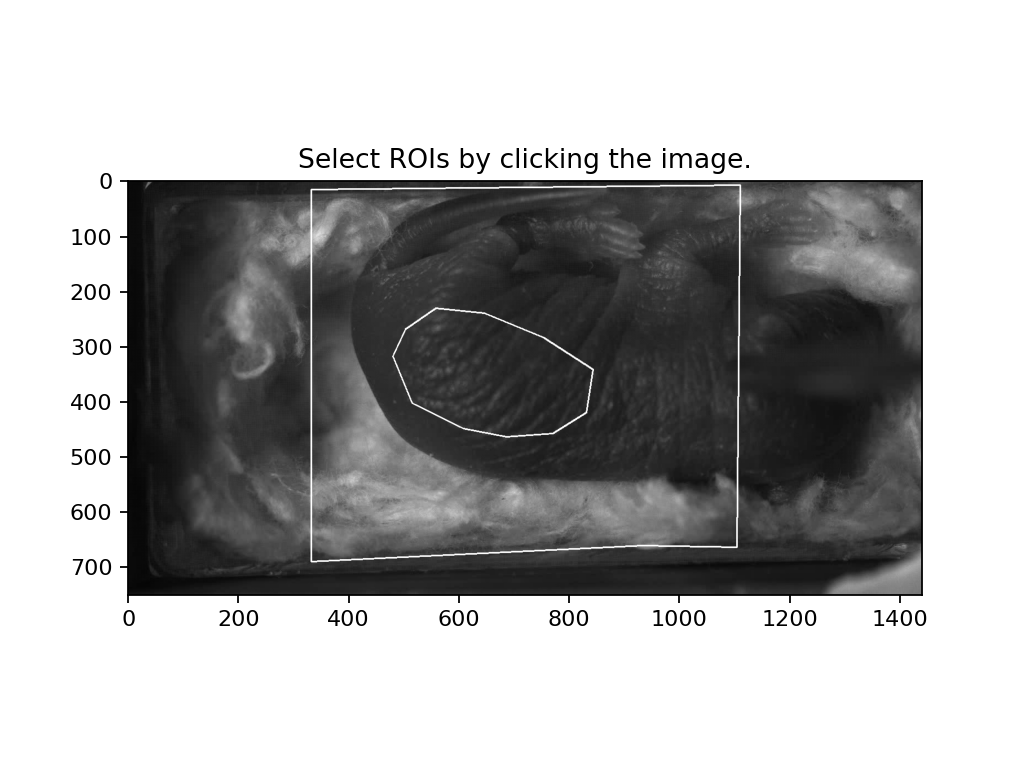

Button(description='Confirm ROI', style=ButtonStyle())

Button(description='New ROI', style=ButtonStyle())

mask_frames computed


In [50]:
# Shawn's notes 3/25/25
# Make the first ROI the region you want to track (dont make it too small, make it big)
# Click new ROI 
# Make the 2nd ROI the masking region (say lower half of chamber)
# Confirm ROI
# if loading from a previous file use select_mode='file', and set path_file
# tips - choose a big ROI, and one that is not close to the edges in case it shifts
# change 2nd number for exampleImage to load a different example frame. from experience though its probably better to trim the video

exampleImage = data[0][0]
# %matplotlib notebook
rois = fr.rois.ROIs(
    select_mode='gui',
#     select_mode='file',
    exampleImage=exampleImage,
#     select_mode='file',
#     path_file=str(Path('/home/rich/Desktop/0322N_and_0322R/mouse_0322N__20230430/') / 'ROIs.h5'),
#     path_file=r'C:\Users\shawn\Desktop\AirPuff_Data\03182025_Cage_PN37\LLM\analysis_files\ROIs.h5',
    verbose=2
)



Make a point grid out of the first ROI

In [51]:
rois.make_points(rois=rois[0], point_spacing=13) if rois.point_positions is None else None

FR: Making points to track
FR: 356 points total


Save the `ROIs` object in the 'analysis_files' project folder

In [52]:
rois.save_config(path_config=path_config, overwrite=True, verbose=1)
rois.save_run_info(path_config=path_config, overwrite=True, verbose=1)
rois.save_run_data(path_config=path_config, overwrite=True, verbose=1)

FR WARNING: path_run_data file is expected to be named 'ROIs.h5' if it is part of a project. Please make sure this is correct.


visualize the ROIs

<IPython.core.display.Javascript object>


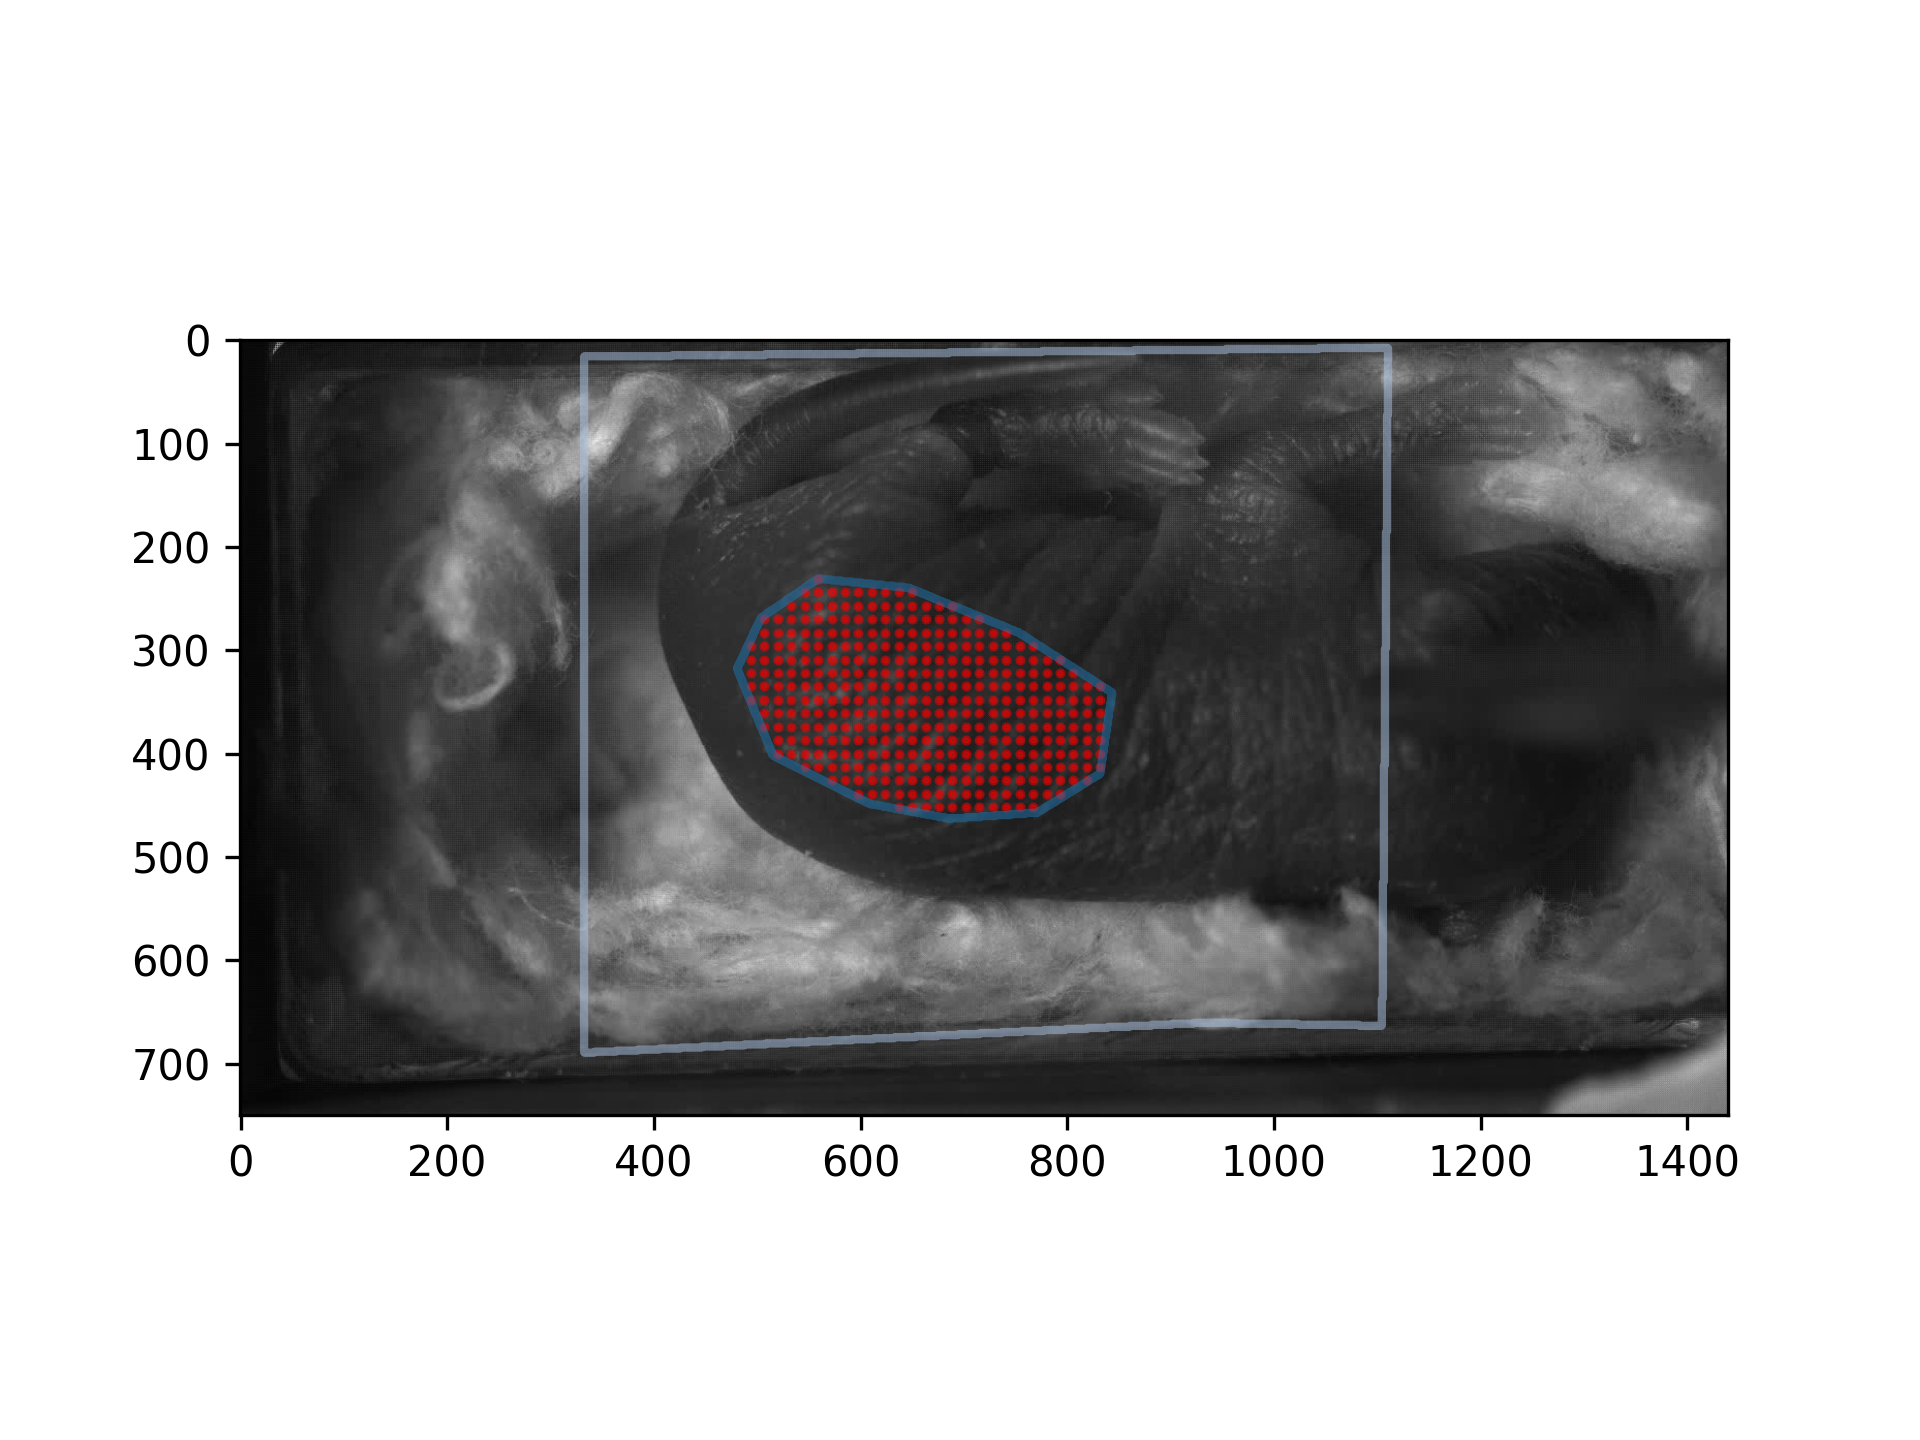

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [53]:
rois.plot_rois(exampleImage)

# Point Tracking

Prepare `PointTracker` object.\
Set `visualize_video` to **`True`** to tune parameters until they look appropriate, then set to **`False`** to run the full dataset through at a much faster speed.

Key parameters:
- `point_spacing`: distance between points. Vary so that total number of points is appropriate.
- `mesh_rigidity`: how rigid the mesh elasticity is. Vary so that points track well without drift.
- `relaxation`: how quickly the points relax back to their home position. Vary so that points track well without dift.
- `kwargs_method > winSize`: the spatial size of the optical flow calculation. Smaller is better but noisier, larger is less accurate but more robust to noise.
- `params_outlier_handling > threshold_displacement`: point displacements above this value will result in freezing of the points.

In [ ]:
# Face rhythm default parameters
#      params_optical_flow = {
#             "method": "lucas_kanade",
#             "mesh_rigidity": 0.005,
#             "mesh_n_neighbors": 10,
#             "relaxation": 0.5,
#             "kwargs_method": {
#                 "winSize": [15,15],
#                 "maxLevel": 2,
#                 "criteria": [cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03],
#             },
#         }


# Face rhythm original notebook parameters
#     params_optical_flow={
#         "method": "lucas_kanade",
#         "mesh_rigidity": 0.02,
#         "mesh_n_neighbors": 70,
#         "relaxation": 0.003,
#         "kwargs_method": {
#             "winSize": [60, 60],
#             "maxLevel": 5,
#             "criteria": [cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.0003],
#         },        
#     },

# Initial parameters from discussion with hakim
#     params_optical_flow={
#         "method": "lucas_kanade",
#         "mesh_rigidity": 0.08,
#         "mesh_n_neighbors": 40,
#         "relaxation": 0.0005,
#         "kwargs_method": {
#             "winSize": [75, 75],
#             "maxLevel": 1,
#             "criteria": [cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 2, 0.0003],
#         },        
#     },

# adjusted parameters 3/25/25
#     params_optical_flow={
#         "method": "lucas_kanade",
#         "mesh_rigidity": 0.15,
#         "mesh_n_neighbors": 35,
#         "relaxation": 0.001,
#         "kwargs_method": {
#             "winSize": [45, 45],
#             "maxLevel": 2,
#             "criteria": [cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5, 0.0003],
#         },        
#     },

In [56]:
pt = fr.point_tracking.PointTracker(
    visualize_video=True,
#     buffered_video_reader=videos[:5],
    buffered_video_reader=videos,
    point_positions=rois.point_positions,
    rois_masks=[rois[1]],
    contiguous=True,
    # Default notebook parameters
#     params_optical_flow={
#         "method": "lucas_kanade",
#         "mesh_rigidity": 0.02,
#         "mesh_n_neighbors": 70,
#         "relaxation": 0.003,
#         "kwargs_method": {
#             "winSize": [60, 60],
#             "maxLevel": 5,
#             "criteria": [cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.0003],
#         },        
#     },
    # Shawn's parameters
    params_optical_flow={
        "method": "lucas_kanade",
        "mesh_rigidity": 0.12,
        "mesh_n_neighbors": 35,
        "relaxation": 0.0015,
        "kwargs_method": {
            "winSize": [75, 75],
            "maxLevel": 3,
            "criteria": [cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.0008],
        },        
    },
    # Default notebook clahe
#     params_clahe={
#         "clipLimit": 60.0,
#         "tileGridSize": (250, 250),
#     },
    # Shawn's parameters
    params_clahe={},
    params_visualization={
        'alpha': 0.9,
        'point_sizes': 3,
    },
    params_outlier_handling = {
        # original notebook parameter
#         'threshold_displacement': 120,  ## Maximum displacement between frames, in pixels.
        # Shawn's parameters
        'threshold_displacement': 500,  ## Maximum displacement between frames, in pixels.
        'framesHalted_before': 10,  ## Number of frames to halt tracking before a violation.
        'framesHalted_after': 10,  ## Number of frames to halt tracking after a violation.
    },
    idx_start=0,  ## generally only change for visualization.
    verbose=2,
)

FR: 356 points will be tracked
FR: Collapsing mask ROI images into single mask
FR: Initializing mesh distances
FR: Preparing playback visualizer


Perform point tracking

In [57]:
pt.track_points()

FR: Setting initial frame_prev
FR: Iterating point tracking through videos



frame #: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57934/57934 [38:34<00:00, 25.04it/s]

video #: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [38:34<00:00, 2314.60s/it]

FR: Tracking complete
FR: Placing points_tracked into dictionary self.points_tracked where keys are video indices
FR: Placing violations into dictionary self.violations where keys are video indices


Save the `PointTracker` object in 'analysis_files' project directory.\
Using compression can reduce file sizes slightly but is very slow.

In [58]:
pt.save_config(path_config=path_config, overwrite=True, verbose=1)
pt.save_run_info(path_config=path_config, overwrite=True, verbose=2)
pt.save_run_data(path_config=path_config, overwrite=True, use_compression=False, verbose=1)

FR: Loading file C:\Users\shawn\Desktop\AirPuff_Data\03182025_Cage_PN37\ULM\run_info.json
FR: Adding 'PointTracker' field to run_info.json
FR: Saving run_info.json to C:\Users\shawn\Desktop\AirPuff_Data\03182025_Cage_PN37\ULM\run_info.json
FR WARNING: path_run_data file is expected to be named 'PointTracker.h5' if it is part of a project. Please make sure this is correct.


Clear some memory if needed. Optional.

In [59]:
pt.cleanup()

FR: Deleting all attributes


Load the `PointTracker` data as a dictionary

In [60]:
pt_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'PointTracker.h5'), return_dict=True, verbose=True)

==== Loading h5 file with hierarchy: ====
1. point_positions:    shape=(356, 2) ,    dtype=float32
2. neighbors:       shape=(356, 35) ,   dtype=int64
3. mesh_d0:         shape=(356, 2) ,    dtype=float32
4. mask:            shape=(750, 1440) , dtype=bool
5. points_tracked:----------------
  1. 0:             shape=(57934, 356, 2) ,dtype=float32
6. violations:----------------
  1. 0:----------------
    1. row:         shape=(17569,) ,    dtype=int32
    2. col:         shape=(17569,) ,    dtype=int32
    3. data:        shape=(17569,) ,    dtype=bool
    4. shape:       shape=(2,) ,        dtype=int32


# Demo video visualization

Playback a video with points overlayed.\
Make sure you have a `BufferedVideoReader` object called `videos` made of your videos

In [61]:
idx_video_to_use = 0
idx_frames_to_use = np.arange(0, 1000)

videos.method_getitem = 'by_video'

frame_visualizer = fr.visualization.FrameVisualizer(
    display=True,
    error_checking=True,
    verbose=2,
    path_save=str(Path(directory_project) / 'visualizations' / 'point_tracking_demo.mp4'),
#     path_save=None,
    frame_height_width=videos.frame_height_width,
    frame_rate=data.frame_rate,
    fourcc="FMP4",
    point_sizes=3,
    points_colors=(0,255,255),
#     points_colors=[(cmap((factor_magnitudes / factor_magnitudes.max(0)))*255)[:,:,:3].astype(int).transpose(1,0,2)[0]],
    alpha=0.6,
)

fr.visualization.play_video_with_points(
    bufferedVideoReader=videos[idx_video_to_use],
    frameVisualizer=frame_visualizer,
    points=list(pt_data['points_tracked'].values())[0],
    idx_frames=idx_frames_to_use,
)

Exception ignored in: <function FrameVisualizer.__del__ at 0x0000029FF97D8EA0>
Traceback (most recent call last):
  File "C:\Users\shawn\anaconda3\envs\face_rhythm\Lib\site-packages\face_rhythm\visualization.py", line 438, in __del__
    self.close()
  File "C:\Users\shawn\anaconda3\envs\face_rhythm\Lib\site-packages\face_rhythm\visualization.py", line 425, in close
    cv2.destroyWindow(self.handle_cv2Imshow)
cv2.error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:1261: error: (-27:Null pointer) NULL window: 'FaceRhythmPointVisualizer' in function 'cvDestroyWindow'



Initializing video writer with frame_rate=100, fourcc=FMP4, frame_height_width=(750, 1440), path_save=C:\Users\shawn\Desktop\AirPuff_Data\03182025_Cage_PN37\ULM\visualizations\point_tracking_demo.mp4
<class 'face_rhythm.helpers.BufferedVideoReader'>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.85it/s]


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:1261: error: (-27:Null pointer) NULL window: 'FaceRhythmPointVisualizer' in function 'cvDestroyWindow'


# Full video visualization

Shawn's notes 3/26/25 Run full video visualization for manual verification of tracking

In [62]:
arr = list(pt_data["points_tracked"].values())[0]
number_of_frames = arr.shape[0]

idx_video_to_use = 0
idx_frames_to_use = np.arange(0, number_of_frames)

videos.method_getitem = 'by_video'

frame_visualizer = fr.visualization.FrameVisualizer(
    display=True,
    error_checking=True,
    verbose=2,
    path_save=str(Path(directory_project) / 'visualizations' / 'full_point_tracking.mp4'),
#     path_save=None,
    frame_height_width=videos.frame_height_width,
    frame_rate=data.frame_rate,
    fourcc="FMP4",
    point_sizes=3,
    points_colors=(0,255,255),
#     points_colors=[(cmap((factor_magnitudes / factor_magnitudes.max(0)))*255)[:,:,:3].astype(int).transpose(1,0,2)[0]],
    alpha=0.6,
)

fr.visualization.play_video_with_points(
    bufferedVideoReader=videos[idx_video_to_use],
    frameVisualizer=frame_visualizer,
    points=list(pt_data['points_tracked'].values())[0],
    idx_frames=idx_frames_to_use,
)

Initializing video writer with frame_rate=100, fourcc=FMP4, frame_height_width=(750, 1440), path_save=C:\Users\shawn\Desktop\AirPuff_Data\03182025_Cage_PN37\ULM\visualizations\full_point_tracking.mp4
<class 'face_rhythm.helpers.BufferedVideoReader'>


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57934/57934 [30:38<00:00, 31.51it/s]


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:1261: error: (-27:Null pointer) NULL window: 'FaceRhythmPointVisualizer' in function 'cvDestroyWindow'
